This code is from this github repo: https://github.com/weixu000/DSH-pytorch

We have used this code to demonstrate for our own project.

The code has been modified.

In [1]:
# %pip install tensorboardX # only run this cell if you are running on Google Colab

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'


In [2]:
import os
import argparse
import torch
import time
from functools import wraps
import matplotlib.pyplot as plt
import numpy as np
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets.cifar import CIFAR10
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
import torch.optim as optim
from tensorboardX import SummaryWriter
import torch.nn as nn
import torch.nn.init as init
import pandas as pd

### Create training and testing data loaders for the CIFAR-10 dataset

In [3]:
def init_cifar_dataloader(root, batch_size):
    normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    train_loader = DataLoader(CIFAR10(root, train=True, download=True, transform=transform_train),
                              batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(CIFAR10(root, train=False, download=True, transform=transform_test),
                             batch_size=batch_size * 8, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, test_loader

### Create training and testing data loaders for the MNIST dataset

In [4]:
def init_mnist_dataloader(root, batch_size):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081)),
    ])
    train_loader = DataLoader(MNIST(root, train=True, download=True, transform=transform),
                              batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(MNIST(root, train=False, download=True, transform=transform),
                             batch_size=batch_size * 8, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, test_loader

### Get the class and binary code of each image in a dataloader by passing the images through the network, then using torch.sign to convert the values to strictly 1/-1

In [5]:
def compute_result(dataloader, net):
    binary_codes, classes = [], []
    net.eval()
    for img, class_ in dataloader:
        classes.append(class_)
        with torch.no_grad():
            binary_codes.append(net(img.cuda()).data.cpu())
    return torch.sign(torch.cat(binary_codes)), torch.cat(classes)

### Compute mean average precision

In [6]:
def compute_mAP(train_binary, test_binary, train_label, test_label):
    for x in train_binary, test_binary, train_label, test_label: x.long()
    AP = []
    Ns = torch.arange(1, train_binary.size(0) + 1)
    for i in range(test_binary.size(0)):
        query_label, query_binary = test_label[i], test_binary[i]
        _, query_result = torch.sum((query_binary != train_binary).long(), dim=1).sort()
        correct = (query_label == train_label[query_result]).float()
        P = torch.cumsum(correct, dim=0) / Ns
        AP.append(torch.sum(P * correct) / torch.sum(correct))
    mAP = torch.mean(torch.Tensor(AP))
    return mAP

### Choose the GPU to run the model on

In [7]:
def choose_gpu(i_gpu):
    torch.cuda.device(i_gpu).__enter__()
    cudnn.benchmark = True

In [8]:
def feed_random_seed(seed=np.random.randint(1, 10000)):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

### Model structure definition

In [9]:
class DSH(nn.Module):
    def __init__(self, num_binary):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 3 * 3, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, num_binary)
        )
        for m in self.modules():
            if m.__class__ == nn.Conv2d or m.__class__ == nn.Linear:
                init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0)


    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### Calculating the loss function for DSH, follows the original paper

In [10]:
def hashing_loss(binary, class_, margin_threshold, alpha):
    y = (class_.unsqueeze(0) != class_.unsqueeze(1)).float().view(-1)
    dist = ((binary.unsqueeze(0) - binary.unsqueeze(1)) ** 2).sum(dim=2).view(-1)
    loss = (1 - y) / 2 * dist + y / 2 * (margin_threshold - dist).clamp(min=0)
    loss = loss.mean() + alpha * (binary.abs() - 1).abs().sum(dim=1).mean() * 2
    return loss

### Train the model

In [11]:
def train(epoch, dataloader, net, optimizer, margin_threshold, alpha):
    accum_loss = 0
    net.train()
    for i, (img, class_) in enumerate(dataloader):
        with torch.no_grad():
            img, cls = [x.cuda() for x in (img, class_)]
        net.zero_grad()
        binary = net(img)
        loss = hashing_loss(binary, class_, margin_threshold, alpha)
        loss.backward()
        optimizer.step()
        accum_loss += loss.data
        print(f'[{epoch}][{i}/{len(dataloader)}] loss: {loss.data:.4f}')
    return accum_loss / len(dataloader)

### Test the model

In [12]:
def test(epoch, dataloader, net, margin_threshold, alpha):
    accum_loss = 0
    net.eval()
    for img, class_ in dataloader:
        with torch.no_grad():
            img, class_ = [x.cuda() for x in (img, class_)]
        binary = net(img)
        loss = hashing_loss(binary, class_, margin_threshold, alpha)
        accum_loss += loss.data
    accum_loss /= len(dataloader)
    print(f'[{epoch}] val loss: {accum_loss:.4f}')
    return accum_loss

### Training and testing the model, using a specified dataset, batch size, learning rate, the regularizer alpha, and number of epochs

In [13]:
def train_and_test(num_binary=12, dataset='cifar', weights='', outf='checkpoints', checkpoint=50, batch_size=256, ngpu=0, alpha=0.01, niter=500, lr=0.001):
    opt = {
        'dataset': dataset,
        'cifar': './dataset/cifar',
        'mnist': './dataset/mnist',
        'weights': weights,
        'outf': outf,
        'checkpoint': checkpoint,
        'batch_size': batch_size,
        'ngpu': ngpu,
        'binary_bits': num_binary,
        'alpha': alpha,
        'niter': niter,
        'lr': lr
    }
    opt = argparse.Namespace(**opt)
    print(opt)

    os.makedirs(opt.outf, exist_ok=True)
    choose_gpu(opt.ngpu)
    feed_random_seed()
    train_loader, test_loader = None, None
    if opt.dataset == 'cifar':
        train_loader, test_loader = init_cifar_dataloader(opt.cifar, opt.batch_size)
    elif opt.dataset == 'mnist':
        train_loader, test_loader = init_mnist_dataloader(opt.mnist, opt.batch_size)
    else:
        raise ValueError(f'unknown dataset: {opt.dataset}')
    logger = SummaryWriter()

    net = DSH(opt.binary_bits)
    resume_epoch = 0
    print(f'batch size: {opt.batch_size}')
    print(f'alpha: {opt.alpha}')
    print(f'learning rate: {opt.lr}')
    print(f'number of epochs: {opt.niter}')
    print(f'binary bits: {opt.binary_bits}')
    if opt.weights:
        print(f'weights loaded from {opt.weights}')
        resume_epoch = int(os.path.basename(opt.weights)[:-4])
        print(f'resume from epoch {resume_epoch}')
        net.load_state_dict(torch.load(opt.weights, map_location=lambda storage, location: storage))

    net.cuda()

    optimizer = optim.Adam(net.parameters(), lr=opt.lr, weight_decay=0.004)

    for epoch in range(resume_epoch + 1, opt.niter + 1):
        train_loss = train(epoch, train_loader, net, optimizer, 2 * opt.binary_bits, opt.alpha)
        logger.add_scalar('train_loss', train_loss, epoch)

        test_loss = test(epoch, test_loader, net, 2 * opt.binary_bits, opt.alpha)
        logger.add_scalar('test_loss', test_loss, epoch)

        if epoch % opt.checkpoint == 0 or epoch == 1:
            # compute mAP by searching testset images from trainset
            train_binary, train_label = compute_result(train_loader, net)
            test_binary, test_label = compute_result(test_loader, net)
            mAP = compute_mAP(train_binary, test_binary, train_label, test_label)
            print(f'[{epoch}] retrieval mAP: {mAP:.4f}')
            logger.add_scalar('retrieval_mAP', mAP, epoch)

            # save checkpoints
            torch.save(net.state_dict(), os.path.join(opt.outf, f'{epoch:03d}.pth'))
    
    return net

### Uncomment the cell below to train the model from scratch

In [14]:
# net = train_and_test(num_binary=48, dataset='cifar', batch_size=256, alpha=0.01, niter=500, lr=0.001)

# Demonstration

# Train the model using the MNIST dataset

- We have already trained the model beforehand, and saved the weights of the model to the 48_mnist_500.pth file.
- We trained the model for 500 epochs, using a batch size of 256, the regularizer alpha of 0.01, a learning rate of 0.001, and the number of binary codes for each image (the number of outputs of the network) is 48.
- A new network will be created and re-use the weights, for demonstration purposes.
- Below is the mAP value over epochs when we trained the model.

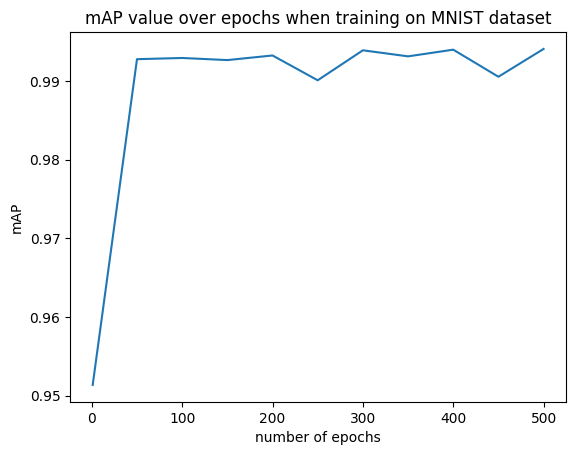

mAP at epoch 500: 0.9940613508224488


In [15]:
df_mnist = pd.read_csv('mnist_mAP.csv')
df_mnist.head()

plt.plot(df_mnist['Step'], df_mnist['Value'])
plt.xlabel('number of epochs')
plt.ylabel('mAP')
plt.title('mAP value over epochs when training on MNIST dataset')
plt.show()

print(f'mAP at epoch 500: {df_mnist.iloc[-1, 2]}')

In [16]:
net_mnist = DSH(48)
net_mnist.load_state_dict(torch.load('./48_mnist_500.pth', map_location=lambda storage, location: storage))
net_mnist.cuda()
net_mnist.eval()

DSH(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): AvgPool2d(kernel_size=3, stride=2, padding=0)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): AvgPool2d(kernel_size=3, stride=2, padding=0)
  )
  (fc): Sequential(
    (0): Linear(in_features=576, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=48, bias=True)
  )
)

### Get the MNIST dataset, and creating dataloaders

In [17]:
transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081)),
])

train_dataset_mnist = MNIST('./dataset/mnist', train=True, download=True, transform=transform_mnist)
train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=1, shuffle=False)

test_dataset_mnist = MNIST('./dataset/mnist', train=False, download=True, transform=transform_mnist)
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=1, shuffle=False)

print(f'Length of train dataset: {len(train_dataset_mnist)}')
print(f'Length of test dataset: {len(test_dataset_mnist)}')

Length of train dataset: 60000
Length of test dataset: 10000


### Get a random image from the test set, and use it as the query image

In [18]:
idx_1 = np.random.randint(0, len(test_dataset_mnist))
print(f'Index of random test image: {idx_1}')
img_1, class_1 = test_dataset_mnist[idx_1]

Index of random test image: 4475


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


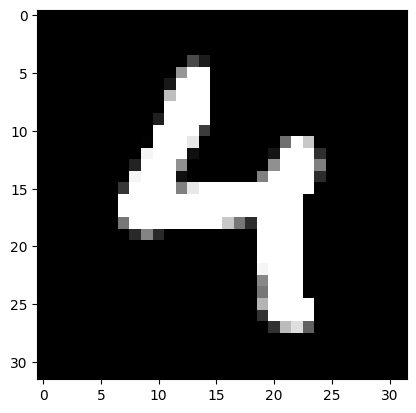

Label of the first image: 4


In [19]:
# print the image
img_1 = img_1.squeeze().cpu().numpy()
img_1 = np.transpose(img_1, (1, 2, 0))
plt.imshow(img_1)
plt.show()

# print the label
print(f'Label of the first image: {class_1}')

### Get the binary codes and the labels of all the images in the training set. This will be used as a database for the query image above

In [20]:
binary_codes_mnist_dataset, labels_mnist_dataset = compute_result(train_loader_mnist, net_mnist)
print(binary_codes_mnist_dataset.shape, labels_mnist_dataset.shape)

torch.Size([60000, 48]) torch.Size([60000])


### Get the binary code, and the class of the query image

In [21]:
img_1_binary, img_1_class = compute_result(DataLoader([test_dataset_mnist[idx_1]], batch_size=1), net_mnist)

In [22]:
print(f'Image 1 binary code: {img_1_binary}')
print(f'Image 1 class: {img_1_class[0]}')

Image 1 binary code: tensor([[ 1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
         -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,  1., -1., -1., -1.,  1.,
          1., -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,
          1.,  1., -1.,  1., -1., -1.]])
Image 1 class: 4


### Calculate the Hamming distance between the query image, and all of the images in the training set database

In [23]:
hamming_dist_mnist = (binary_codes_mnist_dataset != img_1_binary).sum(dim=1)

### Count the number of images in the training set database that have the same binary code as the query image (Hamming distance equals zero)

In [24]:
similar_img_idx_mnist = np.where(hamming_dist_mnist == 0)[0]
print(f'Number of images with hamming distance of 0 to image 1: {len(similar_img_idx_mnist)}')

Number of images with hamming distance of 0 to image 1: 5767


### Within the set of images that have the same binary code with the query image, how many of them have the same class as the query image

In [25]:
count_mnist = 0
for i in similar_img_idx_mnist:
    _, i_class = train_dataset_mnist[i]
    if class_1 == i_class:
        count_mnist += 1
print(f'Number of images with hamming distance of 0 to image 1 with the same class: {count_mnist}')

Number of images with hamming distance of 0 to image 1 with the same class: 5759


In [26]:
print(f'satisfied retrieved images / total retrieved images: {count_mnist / len(similar_img_idx_mnist)}')

satisfied retrieved images / total retrieved images: 0.9986127969481533


### Print the best 50 retrieved images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

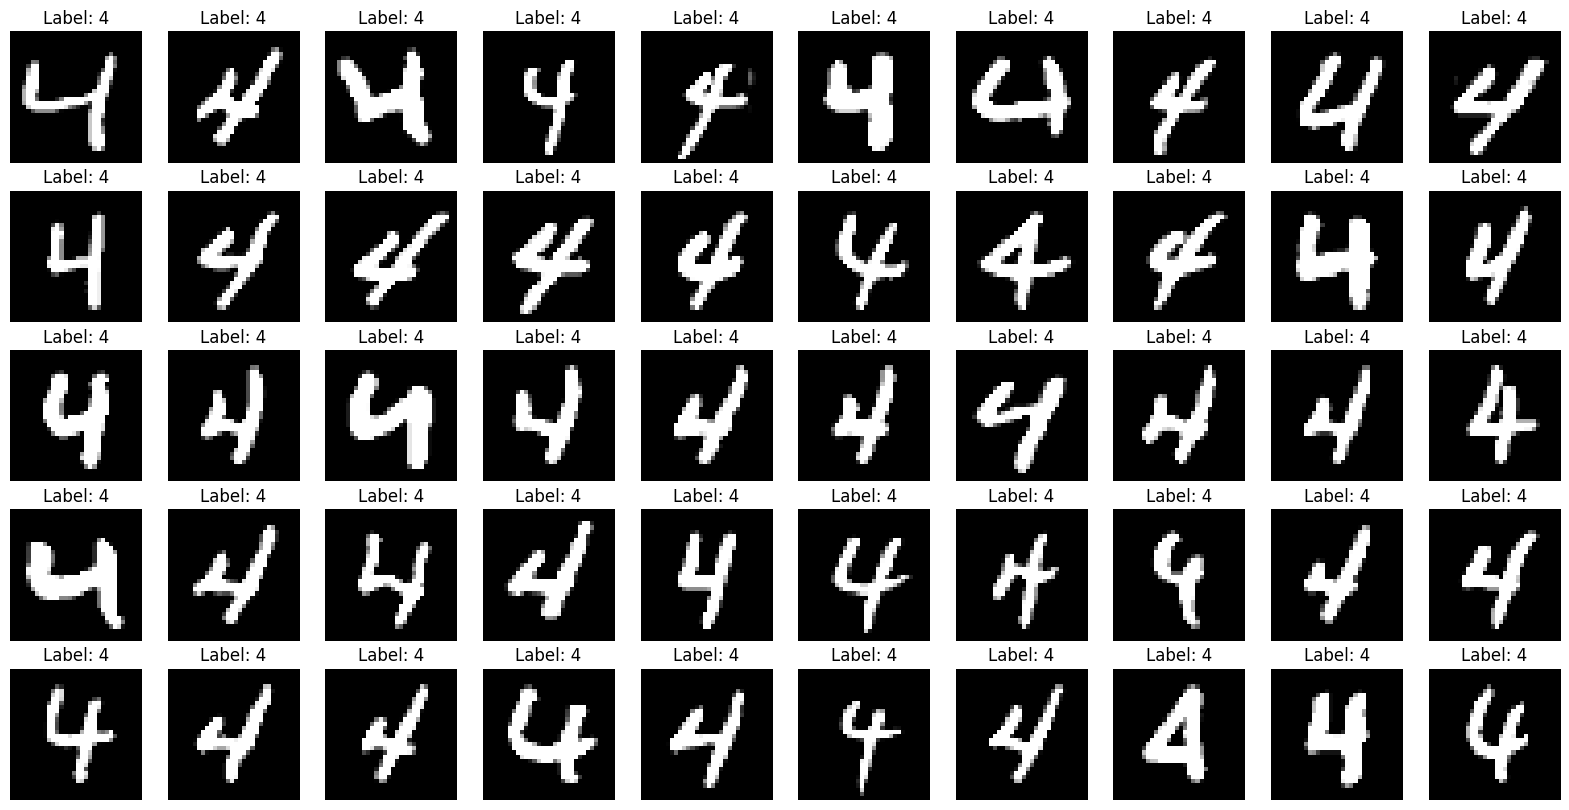

In [27]:
# the similar_img_idx_mnist array is sorted on hamming distance
similar_img_idx_mnist = sorted(similar_img_idx_mnist, key=lambda x: (hamming_dist_mnist[x]))

# print the 50 best retrived images, along with their labels
top_50_mnist = similar_img_idx_mnist[:50]
fig, axs = plt.subplots(5, 10, figsize=(20, 10))
for i, idx in enumerate(top_50_mnist):
    img, label = train_dataset_mnist[idx]
    img = img.squeeze().numpy()
    img = np.transpose(img, (1, 2, 0))
    axs[i // 10, i % 10].imshow(img)
    axs[i // 10, i % 10].set_title(f'Label: {label}')
    axs[i // 10, i % 10].axis('off')


# Train the model using the CIFAR-10 dataset

- Just like above, we have already trained the network with the CIFAR-10 dataset beforehand. We will re-use the weights from the file 48_cifar_500.pth for demonstration purposes.
- And just like above, we trained the model for 500 epochs, using a batch size of 256, the regularizer alpha of 0.01, a learning rate of 0.001, and the number of binary codes for each image (the number of outputs of the network) is 48.
- Below is the mAP value over epochs when we trained the model.

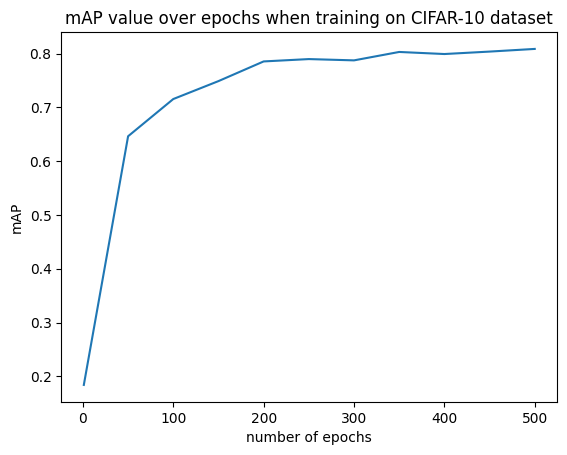

mAP at epoch 500: 0.8086214065551758


In [28]:
df_cifar = pd.read_csv('cifar_mAP.csv')
df_cifar.head()

plt.plot(df_cifar['Step'], df_cifar['Value'])
plt.xlabel('number of epochs')
plt.ylabel('mAP')
plt.title('mAP value over epochs when training on CIFAR-10 dataset')
plt.show()

print(f'mAP at epoch 500: {df_cifar.iloc[-1, 2]}')

In [29]:
# the labels of the cifar dataset
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [30]:
net_cifar = DSH(48)
net_cifar.load_state_dict(torch.load('./48_cifar_500.pth', map_location=lambda storage, location: storage))
net_cifar.cuda()

DSH(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): AvgPool2d(kernel_size=3, stride=2, padding=0)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): AvgPool2d(kernel_size=3, stride=2, padding=0)
  )
  (fc): Sequential(
    (0): Linear(in_features=576, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=48, bias=True)
  )
)

### Get the CIFAR-10 dataset, and creating dataloaders

In [31]:
normalize_cifar = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform_train_cifar = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_cifar
])
transform_test_cifar = transforms.Compose([
    transforms.ToTensor(),
    normalize_cifar
])

train_dataset_cifar = CIFAR10('./dataset/cifar', train=True, download=True, transform=transform_train_cifar)
train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=1, shuffle=False)

test_dataset_cifar = CIFAR10('./dataset/cifar', train=False, download=True, transform=transform_test_cifar)
test_loader_cifar = DataLoader(test_dataset_cifar, batch_size=1, shuffle=False)

print(f'Length of train dataset: {len(train_dataset_cifar)}')
print(f'Length of test dataset: {len(test_dataset_cifar)}')

Files already downloaded and verified
Files already downloaded and verified
Length of train dataset: 50000
Length of test dataset: 10000


### Get a random image from the test set, and use it as the query image

In [32]:
idx_2 = np.random.randint(0, len(test_dataset_cifar))
print(f'Index of random test image: {idx_2}')
img_2, class_2 = test_dataset_cifar[idx_2]

Index of random test image: 8921


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


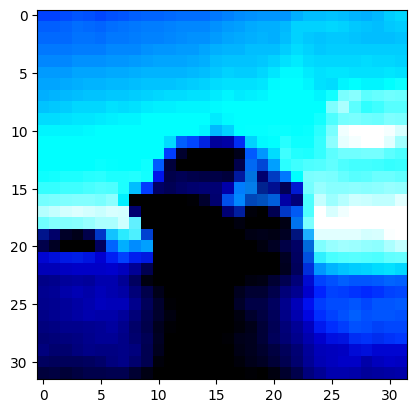

Label of the second image: ship


In [33]:
# print the image
img_2 = img_2.squeeze().cpu().numpy()
img_2 = np.transpose(img_2, (1, 2, 0))
plt.imshow(img_2)
plt.show()

# print the label
print(f'Label of the second image: {cifar_labels[class_2]}')

### Get the binary codes and the labels of all the images in the training set. This will be used as a database for the query image above

In [34]:
binary_codes_cifar_dataset, labels_cifar_dataset = compute_result(train_loader_cifar, net_cifar)
print(binary_codes_cifar_dataset.shape, labels_cifar_dataset.shape)

torch.Size([50000, 48]) torch.Size([50000])


### Get the binary code, and the class of the query image

In [35]:
img_2_binary, img_2_class = compute_result(DataLoader([test_dataset_cifar[idx_2]], batch_size=1), net_cifar)

In [36]:
print(f'Image 2 binary code: {img_2_binary}')
print(f'Image 2 class: {cifar_labels[img_2_class[0]]}')

Image 2 binary code: tensor([[-1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1.,
          1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,
         -1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
          1.,  1.,  1.,  1., -1.,  1.]])
Image 2 class: ship


### Calculate the Hamming distance between the query image, and all of the images in the training set database

In [37]:
hamming_dist_cifar = (binary_codes_cifar_dataset != img_2_binary).sum(dim=1)

### Count the number of images in the training set database that have the Hamming distance with the query image less than or equals to 12

- The CIFAR-10 dataset is much more complex than the MNIST dataset, and so there maybe fewer images with the same binary codes. Thus, we chose the Hamming distance between two images to be considered similar to be 12 or below. The choice of the number 12 is arbitrary.

In [38]:
similar_img_idx_cifar = np.where(hamming_dist_cifar <= 12)[0]
print(f'Number of images with hamming distance of less than 12 to image 2: {len(similar_img_idx_cifar)}')

Number of images with hamming distance of less than 12 to image 2: 4941


### Within the set of images that have the Hamming distance of binary codes less than or equal to 12 with the query image, how many of them have the same class as the query image

In [39]:
count_cifar = 0
for i in similar_img_idx_cifar:
    _, i_class = train_dataset_cifar[i]
    if class_2 == i_class:
        count_cifar += 1
print(f'Number of images with hamming distance of less than or equal to 12 to image 2 with the same class: {count_cifar}')

Number of images with hamming distance of less than or equal to 12 to image 2 with the same class: 4748


In [40]:
print(f'satisfied retrieved images / total retrieved images: {count_cifar / len(similar_img_idx_cifar)}')

satisfied retrieved images / total retrieved images: 0.9609390811576604


### Print the best 50 retrieved images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

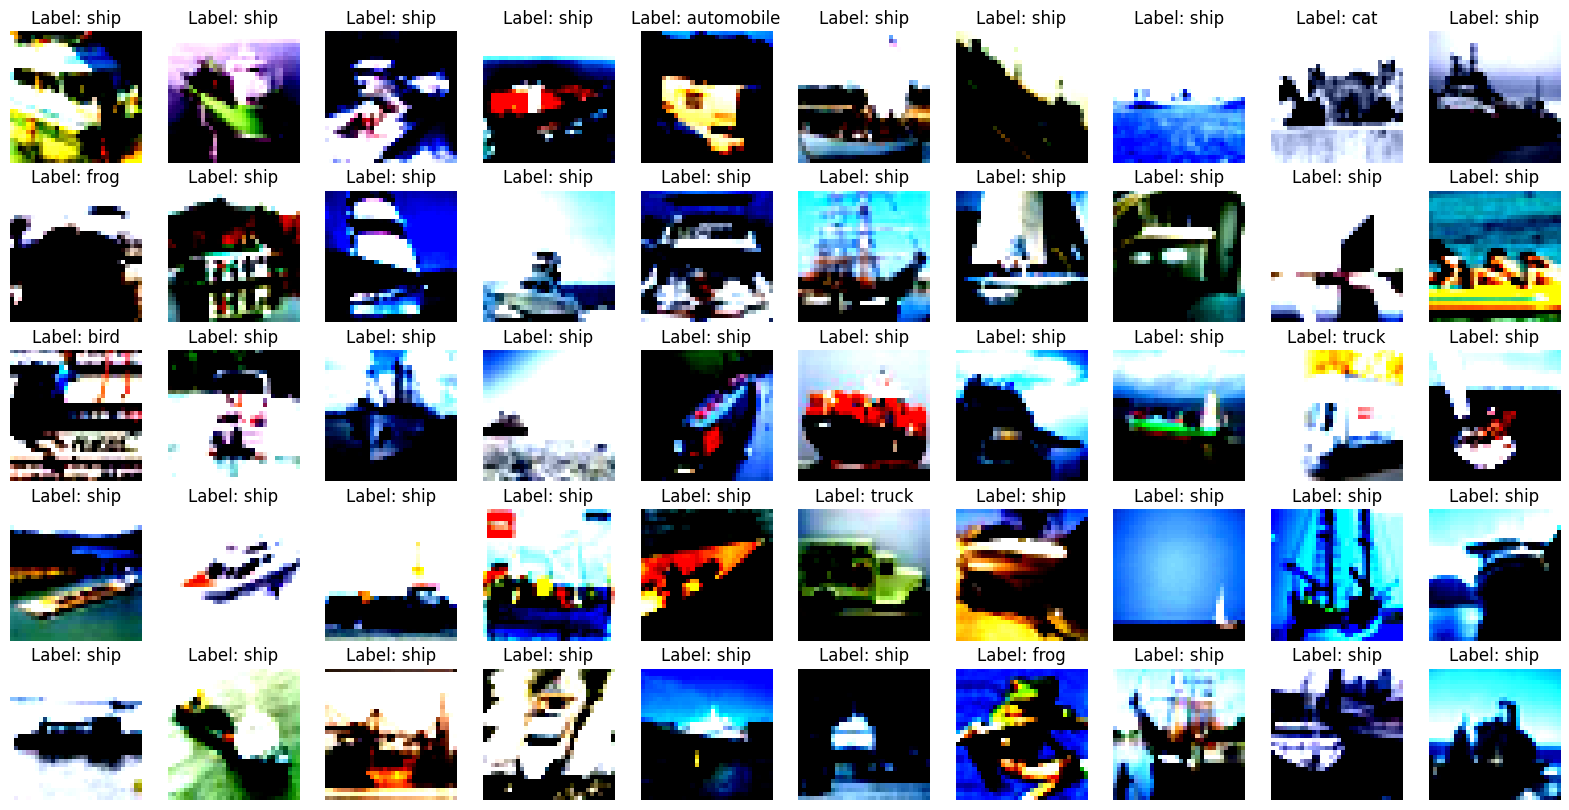

In [41]:
# the similar_img_idx_cifar array is sorted on hamming distance
similar_img_idx_cifar = sorted(similar_img_idx_cifar, key=lambda x: (hamming_dist_cifar[x]))

# print the best 50 retrieved images, along with their labels
top_50_cifar = similar_img_idx_cifar[:50]
fig, axs = plt.subplots(5, 10, figsize=(20, 10))
for i, idx in enumerate(top_50_cifar):
    img, label = train_dataset_cifar[idx]
    img = img.squeeze().numpy()
    img = np.transpose(img, (1, 2, 0))
    axs[i // 10, i % 10].imshow(img)
    axs[i // 10, i % 10].set_title(f'Label: {cifar_labels[label]}')
    axs[i // 10, i % 10].axis('off')